# Examples

## 🧠 LP in scipy

In [1]:
from scipy.optimize import linprog

$$
\begin{align*}
&\min_x c^{\top}x \\
\text{s.t. } & Ax \leq b\\
x_2 \geq -3, \qquad &A = \begin{pmatrix}
    -3       & 1\\
    1      & 2
\end{pmatrix} \qquad b = \begin{pmatrix} 6 \\ 4\end{pmatrix}
\end{align*}
$$

In [2]:
c = [-1, 4]
A = [[-3, 1], [1, 2]]
b = [6, 4]
x0_bounds = (None, None)
x1_bounds = (-3, None)
from scipy.optimize import linprog
res = linprog(c, A_ub=A, b_ub=b, bounds=(x0_bounds, x1_bounds),
              options={"disp": True})

print(res)

Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 -8.0                
0.09885158404625    0.09885158404625    0.09885158404625    0.903461537018   0.09885158404625    -6.284698425658     
0.05788429348353    0.05788429348355    0.05788429348355    0.4273037994111  0.05788429348355    -7.864724729573     
0.04539867008243    0.04539867008244    0.04539867008244    0.2387091287399  0.04539867008244    -12.78916804766     
0.00666151448168    0.006661514481681   0.006661514481682   0.8665142913493  0.006661514481682   -21.3520715063      
6.299626472385e-06  6.299626472585e-06  6.299626472583e-06  1.0              6.299626472588e-06  -21.99681708159     
3.150192408518e-10  3.150193669765e-10  3.150193217394e-10  0.9999499939647  3.150193297574e-10  -21.99999984082     
Optimization terminated successfully.
         Current fu

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


If you want to build tableaus quickly 😀

In [3]:
import scipy

c = [-1, 4]
A = [[-3, 1], [1, 2]]
b = [6, 4]
x0_bounds = (None, None)
x1_bounds = (-3, None)
from scipy.optimize import linprog
res = linprog(c, A_ub=A, b_ub=b, bounds=(x0_bounds, x1_bounds),
              options={"disp": True}, callback=scipy.optimize.linprog_verbose_callback)

Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 -8.0                
--------- Iteration 0  ---------

0.09885158404625    0.09885158404625    0.09885158404625    0.903461537018   0.09885158404625    -6.284698425658     
--------- Iteration 1  ---------

Current Pseudo-Objective Value:
f =  -6.284698425658357

Current Solution Vector:
x =  [     -0.1505      -1.6088]

0.05788429348353    0.05788429348355    0.05788429348355    0.4273037994111  0.05788429348355    -7.864724729573     
--------- Iteration 2  ---------

Current Pseudo-Objective Value:
f =  -7.864724729572676

Current Solution Vector:
x =  [      3.6474      -1.0543]

0.04539867008243    0.04539867008244    0.04539867008244    0.2387091287399  0.04539867008244    -12.78916804766     
--------- Iteration 3  ---------

Current Pseudo-Objective Value:
f =  -12.78

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## 👨‍🔬 Klee, Minty example, when simplex works slow

In [4]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import linprog
import seaborn as sns
sns.set()

def generate_KleeMinty_test_problem(n):
    c = np.array([2**i for i in range(n)])
    c = c[::-1]
    bounds = [(0, None) for i in range(n)]
    b = np.array([5**(i+1) for i in range(n)])
    a = np.array([1] + [2**(i+1) for i in range(1, n)])
    A = np.zeros((n, n))
    for i in range(n):
        A[i:, i] = a[:n-i]
    return -c, A, b, bounds

def generate_random_LP_problem(n):
    c = np.random.rand(n)
    A = np.random.rand(n,n)
    b = np.random.rand(n)
    bounds = []
    for i in range(n):
        bound = (-np.random.rand(1), np.random.rand(1))
        bounds.append(bound)
    return c, A, b, bounds

In [5]:
n = 5
c, A, b, bounds = generate_KleeMinty_test_problem(n)
print(c)
print(A) 
print(b)
print(bounds)

[-16  -8  -4  -2  -1]
[[ 1.  0.  0.  0.  0.]
 [ 4.  1.  0.  0.  0.]
 [ 8.  4.  1.  0.  0.]
 [16.  8.  4.  1.  0.]
 [32. 16.  8.  4.  1.]]
[   5   25  125  625 3125]
[(0, None), (0, None), (0, None), (0, None), (0, None)]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 3.94 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 3.23 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 4.46 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 3.9 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 5.15 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 4.29 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 5.97 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 4.41 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 8.65 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 4.5 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 10 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 4.59 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 10.7 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 5.3 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 12.5 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 4.8 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 14 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 6.16 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 14 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 5.31 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 15.4 ms per loop


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100 loops, best of 5: 6.96 ms per loop


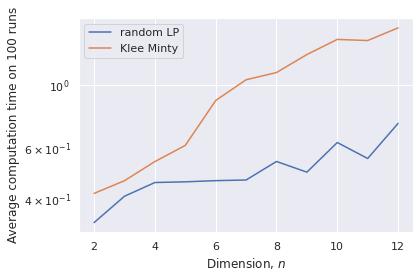

In [6]:
n_list = range(2, 13)

n_iters_km = np.zeros(len(n_list))
times_km   = np.zeros(len(n_list))
n_iters_r  = np.zeros(len(n_list))
times_r    = np.zeros(len(n_list))

for i, n in enumerate(n_list):
    c, A, b, bounds = generate_KleeMinty_test_problem(n)
    res = linprog(c, A, b, bounds=bounds, options={"maxiter": 2**max(n_list)})
    time = %timeit -o -n 100 linprog(c, A, b, bounds=bounds, options={"maxiter": 2**max(n_list) + 1})
    n_iters_km[i] = res.nit
    times_km[i] = np.average(time.all_runs)

    c, A, b, bounds = generate_random_LP_problem(n)
    res = linprog(c, A, b, bounds=bounds, options={"maxiter": 2**max(n_list)})
    time = %timeit -o -n 100 linprog(c, A, b, bounds=bounds, options={"maxiter": 2**max(n_list) + 1})
    n_iters_r[i] = res.nit
    times_r[i] = np.average(time.all_runs)

plt.semilogy(n_list, times_r, label='random LP')
plt.semilogy(n_list, times_km, label = 'Klee Minty')
plt.legend()
plt.xlabel("Dimension, $n$")
plt.ylabel("Average computation time on 100 runs")
plt.tight_layout()
plt.savefig('LP_KM.svg')
plt.show()

## 📼 PuLP library example (Optimal watching TED talks)

In [7]:
!pip install pulp

     |████████████████████████████████| 40.6MB 89kB/s 


In [8]:
%matplotlib inline
 
import pulp
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from IPython.display import Image

In [9]:
# Download the dataset from https://www.kaggle.com/rounakbanik/ted-talks

# Read the dataset into pandas dataframe, convert duration from seconds to minutes
ted = pd.read_csv('https://raw.githubusercontent.com/MerkulovDaniil/optim/master/assets/Notebooks/ted_main.csv', encoding='ISO-8859-1')
ted['duration'] = ted['duration'] / 60
ted = ted.round({'duration': 1})

# Select subset of columns & rows (if required)
# data = ted.sample(n=1000) # 'n' can be changed as required
data = ted
selected_cols = ['name', 'event', 'duration', 'views']
data.reset_index(inplace=True)
data.head()

,index,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,0,4553,Sir Ken Robinson makes an entertaining and pro...,19.4,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,1,265,With the same humor and humanity he exuded in ...,16.3,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,2,124,New York Times columnist David Pogue takes aim...,21.4,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,3,200,"In an emotionally charged talk, MacArthur-winn...",18.6,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,4,593,You've never seen data presented like this. Wi...,19.8,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [10]:
# create LP object,
# set up as a maximization problem --> since we want to maximize the number of TED talks to watch
prob = pulp.LpProblem('WatchingTEDTalks', pulp.LpMaximize)

In [11]:
# create decision - yes or no to watch the talk?
decision_variables = []
for rownum, row in data.iterrows():
    variable = str('x' + str(row['index']))
    variable = pulp.LpVariable(str(variable), lowBound = 0, upBound = 1) # make variable binary
    decision_variables.append(variable)
    
print('Total number of decision variables: ' + str(len(decision_variables)))

Total number of decision variables: 2550


In [12]:
# Create optimization Function
total_views = ''
for rownum, row in data.iterrows():
    for i,talk in enumerate(decision_variables):
        if rownum == i:
            formula = (len(row['description']) + (-1)*row['views']) * talk
            total_views += formula
            
prob += total_views
# print('Optimization function: ' + str(total_views))

In [13]:
# Contraints
total_time_available_for_talks = 3*60 # Total time available is 5 hours . Converted to minutes
total_talks_can_watch = 8 # Don't want an overload information

In [14]:
# Create Constraint 1 - Time for talks
total_time_talks = ''
for rownum, row in data.iterrows():
    for i,  talk in enumerate(decision_variables):
        if rownum == i:
            formula = row['duration']*talk
            total_time_talks += formula
            
prob += (total_time_talks <= total_time_available_for_talks)

In [15]:
# Create Constraint 2 - Number of talks
total_talks = ''

for rownum, row in data.iterrows():
    for i, talk in enumerate(decision_variables):
        if rownum == i:
            formula = talk
            total_talks += formula
            
prob += (total_talks == total_talks_can_watch)

In [16]:
# Be careful, the output will be huge
# print(prob)
prob.writeLP('WatchingTEDTalks.lp')
print('🤔 The problem has successfully formulated')

🤔 The problem has successfully formulated


In [17]:
optimization_result = prob.solve()

assert optimization_result == pulp.LpStatusOptimal
print('Status:', pulp.LpStatus[prob.status])
print('Optimal Solution to the problem: ', pulp.value(prob.objective))
print('Individual decision variables: ')


for v in prob.variables():
    if v.varValue > 0:
        print(v.name, '=', v.varValue)

Status: Optimal
Optimal Solution to the problem:  -784644.0
Individual decision variables: 
x1079 = 1.0
x1112 = 1.0
x1133 = 1.0
x1141 = 1.0
x1229 = 1.0
x237 = 1.0
x594 = 1.0
x776 = 1.0


In [18]:
# reorder results
variable_name = []
variable_value = []

for v in prob.variables():
    variable_name.append(v.name)
    variable_value.append(v.varValue)
    
df = pd.DataFrame({'index': variable_name, 'value': variable_value})
for rownum, row in df.iterrows():
    value = re.findall(r'(\d+)', row['index'])
    df.loc[rownum, 'index'] = int(value[0])
    
# df = df.sort_index(by = 'index')
df = df.sort_values(by = 'index')
result = pd.merge(data, df, on = 'index')
result = result[result['value'] == 1].sort_values(by = 'views', ascending = False)
selected_cols_final = ['name', 'event', 'duration', 'views']
final_set_of_talks_to_watch = result[selected_cols_final]

In [19]:
from IPython.display import display, HTML
display(HTML(final_set_of_talks_to_watch.to_html(index=False)))

name,event,duration,views
Leslie Dodson: Don't misrepresent Africa,TEDxBoulder 2011,11.4,121186
Keith Nolan: Deaf in the military,TEDxIslay,18.6,120274
JosÃ© Bowen: Beethoven the businessman,TEDxSMU,12.8,117756
Aleph Molinari: Let's bridge the digital divide!,TEDxSanMigueldeAllende,9.9,115346
Tim Birkhead: The early birdwatchers,The Do Lectures,28.2,112321
"Rokia Traore: ""Kounandi""",TEDGlobal 2007,6.4,82488
Charles Hazlewood + British Paraorchestra: The debut of the British Paraorchestra,TEDxBrussels,13.6,66668
Edwidge Danticat: Stories of Haiti,University of California,59.6,50443


## 🌮 Diet problem with PyOMO

[source](https://nbviewer.jupyter.org/github/Pyomo/PyomoGallery/blob/master/diet/DietProblem.ipynb)

![](https://fmin.xyz/docs/methods/diet_LP.svg)

Imagine, that you have to construct a diet plan from some set of products: 🍌🍰🍗🥚🐟. Each of the products has its own vector of nutrients. Thus, all the food information could be processed through the matrix $W$. Let also assume, that we have the vector of requirements for each of nutrients $r \in \mathbb{R}^n$. We need to find the cheapest configuration of the diet, which meets all the requirements:

$$
\begin{align*}
&\min_{x \in \mathbb{R}^p} c^{\top}x \\
\text{s.t. } & Wx \geq r\\
& x_i \geq 0, \; i = 1,\dots, n
\end{align*}
$$


In [20]:
!pip install pyomo

     |████████████████████████████████| 9.5MB 3.7MB/s 
     |████████████████████████████████| 256kB 39.3MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 163kB 39.9MB/s 


In [21]:
# Installing cbc solver
import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

from pyomo.environ import *

Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.16.11+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.59.10+repack1-1_amd64.deb ...
Unpacking coinor-libcgl1 (0.59.10+repack1-1) ...
Selecting previously unselected package coinor-libcbc3.
Preparing to unpack .../4-coinor-libcbc3_2.9.9+repack1-1_amd64.deb ...
Unpacking coinor-libcbc3 (2.9.9+repack1-1) ...
Selecting p

In [38]:
# Creating pyomo model
from pyomo.environ import *
infinity = float('inf')

model = AbstractModel()

In [39]:
# Foods (products)
model.p = Set()
# Nutrients
model.n = Set()

In [40]:
# Cost of each food
model.c    = Param(model.p, within=PositiveReals)

# Amount of nutrient in each food
model.W    = Param(model.p, model.n, within=NonNegativeReals)

# Lower and upper bound on each nutrient
model.Nmin = Param(model.n, within=NonNegativeReals, default=0.0)
model.Nmax = Param(model.n, within=NonNegativeReals, default=infinity)

In [41]:
# Defining variables
# Number of servings consumed of each food
model.x = Var(model.p, within=NonNegativeIntegers) 

In [42]:
# Defining cost function
# Minimize the cost of food that is consumed
def cost_rule(model):
    return sum(model.c[i]*model.x[i] for i in model.p)
model.cost = Objective(rule=cost_rule)

In [43]:
# Defining the constraints
# Limit nutrient consumption for each nutrient
def nutrient_rule(model, j):
    value = sum(model.W[i,j]*model.x[i] for i in model.p)
    return model.Nmin[j] <= value <= model.Nmax[j]
model.nutrient_limit = Constraint(model.n, rule=nutrient_rule)

# Limit the volume of food consumed
# def volume_rule(model):
#     return sum(model.V[i]*model.x[i] for i in model.F) <= model.Vmax
# model.volume = Constraint(rule=volume_rule)

# model.volume_min = Constraint(rule=volume_rule)

In [44]:
# Donwloading file locally
!pip install wget
import wget
import os

print('Beginning file download with wget module')

if os.path.exists('LP_diet_pyomo.py'):
    os.remove('LP_diet_pyomo.py') 
url = 'https://raw.githubusercontent.com/MerkulovDaniil/optim/master/assets/Notebooks/LP_diet_pyomo.py'
wget.download(url, 'LP_diet_pyomo.py')

if os.path.exists('LP_diet_data.dat'):
    os.remove('LP_diet_data.dat') 
url = 'https://raw.githubusercontent.com/MerkulovDaniil/optim/master/assets/Notebooks/LP_diet_data.dat'
wget.download(url, 'LP_diet_data.dat')

Beginning file download with wget module


'LP_diet_data.dat'

In [45]:
!cat LP_diet_pyomo.py

# Creating pyomo model
from pyomo.environ import *
infinity = float('inf')

model = AbstractModel()

# Foods (products)
model.p = Set()
# Nutrients
model.n = Set()

# Cost of each food
model.c    = Param(model.p, within=PositiveReals)

# Amount of nutrient in each food
model.W    = Param(model.p, model.n, within=NonNegativeReals)

# Lower and upper bound on each nutrient
model.Nmin = Param(model.n, within=NonNegativeReals, default=0.0)
model.Nmax = Param(model.n, within=NonNegativeReals, default=infinity)

# Defining variables
# Number of servings consumed of each food
model.x = Var(model.p, within=NonNegativeIntegers) 

# Defining cost function
# Minimize the cost of food that is consumed
def cost_rule(model):
    return sum(model.c[i]*model.x[i] for i in model.p)
model.cost = Objective(rule=cost_rule)

# Defining the constraints
# Limit nutrient consumption for each nutrient
def nutrient_rule(model, j):
    value = sum(model.W[i,j]*model.x[i] for i in model.p)
    return model.Nmin[j

In [46]:
!cat LP_diet_data.dat

param:  p:                          c :=
  "Cheeseburger"                 1.84  
  "Ham Sandwich"                 2.19  
  "Hamburger"                    1.84  
  "Fish Sandwich"                1.44  
  "Chicken Sandwich"             2.29  
  "Fries"                         .77  
  "Sausage Biscuit"              1.29  
  "Lowfat Milk"                   .60 
  "Orange Juice"                  .72 ;

param:  n:       Nmin   Nmax :=
        Cal      2000      .
        Carbo     350    375
        Protein    55      .
        VitA      100      .
        VitC      100      .
        Calc      100      .
        Iron      100      . ;

param W:
                               Cal  Carbo Protein   VitA   VitC  Calc  Iron :=
  "Cheeseburger"               510     34     28     15      6    30    20
  "Ham Sandwich"               370     35     24     15     10    20    20
  "Hamburger"                  500     42     25      6      2    25    20
  "Fish Sandwich"              370     38     14

In [47]:
!pyomo solve --solver=cbc LP_diet_pyomo.py LP_diet_data.dat

[    0.00] Setting up Pyomo environment
[    0.00] Applying Pyomo preprocessing actions
[    0.00] Creating model
    function to express ranged inequality expressions. (called from
    /content/LP_diet_pyomo.py:36)
    function to express ranged inequality expressions. (called from
    /content/LP_diet_pyomo.py:36)
    function to express ranged inequality expressions. (called from
    /content/LP_diet_pyomo.py:36)
    function to express ranged inequality expressions. (called from
    /content/LP_diet_pyomo.py:36)
    function to express ranged inequality expressions. (called from
    /content/LP_diet_pyomo.py:36)
    function to express ranged inequality expressions. (called from
    /content/LP_diet_pyomo.py:36)
    function to express ranged inequality expressions. (called from
    /content/LP_diet_pyomo.py:36)
[    0.10] Applying solver
[    0.20] Processing results
    Number of solutions: 1
    Solution Information
      Gap: 0.0
      Status: optimal
      Function Value: 15.0

In [48]:
!cat results.json

{
    "Problem": [
        {
            "Lower bound": 15.05,
            "Name": "unknown",
            "Number of binary variables": 0,
            "Number of constraints": 8,
            "Number of integer variables": 9,
            "Number of nonzeros": 9,
            "Number of objectives": 1,
            "Number of variables": 9,
            "Sense": "minimize",
            "Upper bound": 15.05
        }
    ],
    "Solution": [
        {
            "number of solutions": 1,
            "number of solutions displayed": 1
        },
        {
            "Constraint": "No values",
            "Gap": 0.0,
            "Message": null,
            "Objective": {
                "cost": {
                    "Value": 15.05
                }
            },
            "Problem": {},
            "Status": "optimal",
            "Variable": {
                "x[Cheeseburger]": {
                    "Value": 4.0
                },
                "x[Fish Sandwich]": {
                  

## 📉 Production plans

[source](https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/02.01-Production-Models-with-Linear-Constraints.ipynb#scrollTo=izk2tTP1ecII)

### Example: Production plan for a single product plant

Suppose you are thinking about starting up a business to produce Product X. You have determined there is a market for X of up to 40 units per week at a price of USD 270 each. The production of each unit requires USD 100 of raw materials, 1 hour of type A labor, and 2 hours of type B labor. You have an unlimited amount of raw material available to you, but only 80 hours per week of labor A at a cost of USD 50/hour, and 100 hours per week of labor B at a cost of USD 40 per hour. Ignoring all other expenses, what is the maximum weekly profit?

To get started on this problem, we sketch a flow diagram illustrating the flow of raw materials and labor through the production plant.

![LP_ProductX.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/LP_ProductX.png?raw=1)

The essential decision we need to make is how many units or Product X to produce each week. That's our *decision variable* which we denote as $x$. The weekly revenues are then

$$
\mbox{Revenue} = \$270 x
$$

The costs include the value of the raw materials and each form of labor. If we produce x units a week, then the total cost is

$$
\mbox{Cost} = \underbrace{\$100 x}_{\mbox{Raw Material}} + \underbrace{\$50 x}_{\mbox{Labor A}} + \underbrace{2\times\$40 x}_{\mbox{Labor B}} = \$230 x
$$
    
We see immediately that the gross profit is just


\begin{split}
\mbox{Profit} & = & \mbox{Revenue} - \mbox{Cost} \\
& = & \$ 270x - \$ 230x \\
& = & \$ 40 x
\end{split}


which means there is a profit earned on each unit of X produced, so let's produce as many as possible. 

There are three constraints that limit how many units can be produced. There is market demand for no more than 40 units per week. Producing $x = 40$ units per week will require 40 hours per week of Labor A, and 80 hours per week of Labor B. Checking those constraints we see that we have enough labor of each type, so the maximum profit will be

$$
\max \mbox{Profit} = $40 \mbox{ per unit} \times 40 \mbox{ units per week} = \$1600 \mbox{ per week}
$$

What we conclude is that market demand is the 'most constraining constraint.' Once we've made that deduction, the rest is a straightforward problem that can be solved by inspection.  

While this problem can be solved by inspection, here we show a Pyomo model that generates a solution to the problem.

In [49]:
model = ConcreteModel()

# declare decision variables
model.x = Var(domain=NonNegativeReals)

# declare objective
model.profit = Objective(
    expr = 40*model.x,
    sense = maximize)

# declare constraints
model.demand = Constraint(expr = model.x <= 40)
model.laborA = Constraint(expr = model.x <= 80)
model.laborB = Constraint(expr = 2*model.x <= 100)

# solve
SolverFactory('cbc').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1600.0
  Upper bound: 1600.0
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 2
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of created s

The results of the solution step show the solver has converged to an optimal solution. Next we display the particular components of the model of interest to us.

In [50]:
print("Profit = ", model.profit(), " per week")
print("X = ", model.x(), " units per week")

Profit =  1600.0  per week
X =  40.0  units per week


#### Simple exercises

1. Suppose the demand could be increased to 50 units per month. What would be the increased profits?  What if the demand increased to 60 units per month?  How much would you be willing to pay for your marketing department for the increased demand?

2. Increase the cost of LaborB. At what point is it no longer financially viable to run the plant?

### Production plan: Product Y

Your marketing department has developed plans for a new product called Y. The product sells at a price of USD 210/each, and they expect that you can sell all that you can make. It's also cheaper to make, requiring only USD 90 in raw materials, 1 hour of Labor type A at USD 50 per hour, and 1 hour of Labor B at USD 40 per hour. What is the potential weekly profit?

![LP_ProductY.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/LP_ProductY.png?raw=1)

In [51]:
model = ConcreteModel()

# declare decision variables
model.y = Var(domain=NonNegativeReals)

# declare objective
model.profit = Objective(
    expr = 30*model.y,
    sense = maximize)

# declare constraints
model.laborA = Constraint(expr = model.y <= 80)
model.laborB = Constraint(expr = model.y <= 100)

# solve
SolverFactory('cbc').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2400.0
  Upper bound: 2400.0
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 2
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of created s

In [52]:
print("Profit = ", model.profit())
print("Units of Y = ", model.y())

Profit =  2400.0
Units of Y =  80.0


Compared to product X, we can manufacture and sell up 80 units per week for a total profit of \$2,400. This is very welcome news. 

#### Simple exercises

1. What is the limiting resource?  That is, which of the two types of labor limits the capacity of your plant to produce more units of Y?

2. What rate would you be willing to pay for the additional labor necessary to increase the production of Y?

### Production plan: Mixed product strategy

So far we have learned that we can make $\$1,600$ per week by manufacturing product X, and $\$2,400$ per week manufacturing product Y.  Is it possible to do even better?

To answer this question, we consider the possibilty of manufacturing both products in the same plant. The marketing department assures us that product Y will not affect the sales of product X.  So the same constraints hold as before, but now we have two decision variables, $x$ and $y$.

![LP_ProductXY.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/LP_ProductXY.png?raw=1)

In [53]:
model = ConcreteModel()

# declare decision variables
model.x = Var(domain=NonNegativeReals)
model.y = Var(domain=NonNegativeReals)

# declare objective
model.profit = Objective(
    expr = 40*model.x + 30*model.y,
    sense = maximize)

# declare constraints
model.demand = Constraint(expr = model.x <= 40)
model.laborA = Constraint(expr = model.x + model.y <= 80)
model.laborB = Constraint(expr = 2*model.x + model.y <= 100)

# solve
SolverFactory('cbc').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2600.0
  Upper bound: 2600.0
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 3
  Number of nonzeros: 2
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of created s

In [54]:
# display solution
print("Profit = ", model.profit())
print("Units of X = ", model.x())
print("Units of Y = ", model.y())

Profit =  2600.0
Units of X =  20.0
Units of Y =  60.0


The mixed product strategy earns more profit than either of the single product srategies. Does this surprise you?  Before going further, try to explain why it is possible for a mixed product strategy to earn more profit than either of the possible single product strategies.

### What are the active constraints?

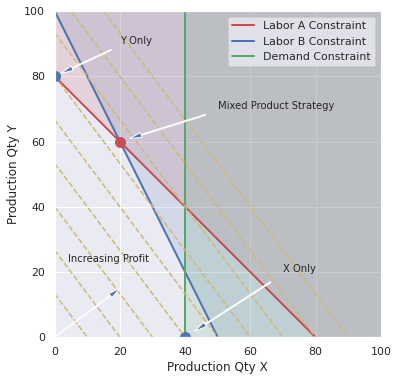

In [55]:
plt.figure(figsize=(6, 6))
plt.subplot(111, aspect='equal')
plt.axis([0, 100, 0, 100])
plt.xlabel('Production Qty X')
plt.ylabel('Production Qty Y')

# Labor A constraint
x = np.array([0, 80])
y = 80 - x
plt.plot(x, y, 'r', lw=2)
plt.fill_between([0, 80, 100], [80, 0,0 ], [100, 100, 100], color='r', alpha=0.15)

# Labor B constraint
x = np.array([0, 50])
y = 100 - 2*x
plt.plot(x, y, 'b', lw=2)
plt.fill_between([0, 50, 100], [100, 0, 0], [100, 100, 100], color='b', alpha=0.15)

# Demand constraint
plt.plot([40, 40], [0, 100], 'g', lw=2)
plt.fill_between([40, 100], [0, 0], [100, 100], color='g', alpha=0.15)

plt.legend(['Labor A Constraint', 'Labor B Constraint', 'Demand Constraint'])

# Contours of constant profit
x = np.array([0, 100])
for p in np.linspace(0, 3600, 10):
    y = (p - 40*x)/30
    plt.plot(x, y, 'y--')

# Optimum
plt.plot(20, 60, 'r.', ms=20)
plt.annotate('Mixed Product Strategy', xy=(20, 60), xytext=(50, 70), 
             arrowprops=dict(shrink=.1, width=1, headwidth=5))

plt.plot(0, 80, 'b.', ms=20)
plt.annotate('Y Only', xy=(0, 80), xytext=(20, 90), 
             arrowprops=dict(shrink=0.1, width=1, headwidth=5))

plt.plot(40, 0, 'b.', ms=20)
plt.annotate('X Only', xy=(40, 0), xytext=(70, 20), 
             arrowprops=dict(shrink=0.1, width=1, headwidth=5))

plt.text(4, 23, 'Increasing Profit')
plt.annotate('', xy=(20,15), xytext=(0,0), 
             arrowprops=dict(width=0.5,headwidth=5))

fname = 'LPprog01.png'
fname = os.path.join('figures', fname) if os.path.exists('figures') else fname
plt.savefig(fname, bbox_inches='tight')

## 🍺🤔 ➡ 🍻😀 Pivko Blending problem

### Problem Statement (Jenchura, 2017)

A brewery receives an order for 100 gallons of 4% ABV (alchohol by volume) beer. The brewery has on hand beer A that is 4.5% ABV that cost USD 0.32 per gallon to make, and beer B that is 3.7% ABV and cost USD 0.25 per gallon. Water could also be used as a blending agent at a cost of USD 0.05 per gallon. Find the minimum cost blend that meets the customer requirements.

### Representing Problem Data as a Python Dictionary

We will use this problem as an opportunity to write a Python function that accepts data on raw materials and customer specifications to produce the lowest cost blend.

The first step is to represent the problem data in a generic manner that could, if needed, be extended to include additional blending components.  Here we use a dictionary of materials, each key denoting a blending agent. For each key there is a sub-dictionary containing attributes of each blending component.

In [56]:
data = {
    'Okhota': {'abv': 0.045, 'cost': 0.32},
    'Baltika': {'abv': 0.037, 'cost': 0.25},
    'Water': {'abv': 0.000, 'cost': 0.05},
}

### Model Formulation

#### Objective Function

If we let subscript $c$ denote a blending component from the set of blending components $C$, and denote the volume of $c$ used in the blend as $x_c$, the cost of the blend is

\begin{align}
\mbox{cost} & = \sum_{c\in C} x_c P_c
\end{align}

where $P_c$ is the price per unit volume of $c$. Using the Python data dictionary defined above, the price $P_c$ is given by `data[c]['cost']`.


#### Volume Constraint

The customer requirement is produce a total volume $V$. Assuming ideal solutions, the constraint is given by

\begin{align}
V &  = \sum_{c\in C} x_c
\end{align}

where $x_c$ denotes the volume of component $c$ used in the blend.


#### Product Composition Constraint

The product composition is specified as 4% alchohol by volume. Denoting this as $\bar{A}$, the constraint may be written as

\begin{align}
\bar{A} & = \frac{\sum_{c\in C}x_c A_c}{\sum_{c\in C} x_c}
\end{align}

where $A_c$ is the alcohol by volume for component $c$. As written, this is a nonlinear constraint. Multiplying both sides of the equation by the denominator yields a linear constraint

\begin{align}
\bar{A}\sum_{c\in C} x_c & = \sum_{c\in C}x_c A_c
\end{align}

A final form for this constraint can be given in either of two versions. In the first version we subtract the left-hand side from the right to give

\begin{align}
0 & = \sum_{c\in C}x_c \left(A_c - \bar{A}\right) & \mbox{ Version 1 of the linear blending constraint}
\end{align}

Alternatively, the summation on the left-hand side corresponds to total volume. Since that is known as part of the problem specification, the blending constraint could also be written as

\begin{align}
\bar{A}V & = \sum_{c\in C}x_c A_c  & \mbox{ Version 2 of the linear blending constraint}
\end{align}

Which should you use? Either will generally work well. The advantage of version 1 is that it is fully specified by a product requirement $\bar{A}$, which is sometimes helpful in writing elegant Python code.


### Implementation in Pyomo

A Pyomo implementation of this blending model is shown in the next cell. The model is contained within a Python function so that it can be more easily reused for additional calculations, or eventually for use by the process operator.

Note that the pyomo library has been imported with the prefix `pyomo`. This is good programming practive to avoid namespace collisions with problem data.

In [57]:
vol = 100
abv = 0.04

def beer_blend(vol, abv, data):
    C = data.keys()
    model = ConcreteModel()
    model.x = Var(C, domain=NonNegativeReals)
    model.cost = Objective(expr = sum(model.x[c]*data[c]['cost'] for c in C))
    model.vol = Constraint(expr = vol == sum(model.x[c] for c in C))
    model.abv = Constraint(expr = 0 == sum(model.x[c]*(data[c]['abv'] - abv) for c in C))

    solver = SolverFactory('cbc')
    solver.solve(model)

    print('Optimal Blend')
    for c in data.keys():
        print('  ', c, ':', model.x[c](), 'gallons')
    print()
    print('Volume = ', model.vol(), 'gallons')
    print('Cost = $', model.cost())
    
beer_blend(vol, abv, data)

Optimal Blend
   Okhota : 37.5 gallons
   Baltika : 62.5 gallons
   Water : 0.0 gallons

Volume =  100.0 gallons
Cost = $ 27.625


## MIP: 🎒 Knapsack

In [58]:
!pip install mip --quiet

     |████████████████████████████████| 48.0MB 95kB/s 


![wikipedia](https://upload.wikimedia.org/wikipedia/commons/f/fd/Knapsack.svg)

As a first example, consider the solution of the 0/1 knapsack problem: given a set $I$ of items, each one with a weight $w_i$ and estimated profit $p_i$, one wants to select a subset with maximum profit such that the summation of the weights of the selected items is less or equal to the knapsack capacity $c$. Considering a set of decision binary variables $x_i$ that receive value $1$ if the $i$-th item is selected, or $0$ if not, the resulting mathematical programming formulation is:

\begin{split}
\textrm{Maximize: }   &  \\
                               &  \sum_{i \in I} p_i \cdot x_i  \\
\textrm{Subject to: } & \\
                               &  \sum_{i \in I} w_i \cdot x_i \leq c  \\
                               &  x_i \in \{0,1\} \,\,\, \forall i \in I
\end{split}



In [59]:
from mip import Model, xsum, maximize, BINARY

p = [10, 13, 18, 31, 7, 15]
w = [11, 15, 20, 35, 10, 33]
c, I = 47, range(len(w))

m = Model("knapsack")

x = [m.add_var(var_type=BINARY) for i in I]

m.objective = maximize(xsum(p[i] * x[i] for i in I))

m += xsum(w[i] * x[i] for i in I) <= c

m.optimize()

selected = [i for i in I if x[i].x >= 0.99]
print("selected items: {}".format(selected))

selected items: [0, 3]


# Exercises


## Task 1. 📱🎧💻 Covers manufacturing

Random Corp is producing covers for following products: 
* 📱 phones
* 🎧 headphones
* 💻 laptops

The company’s production facilities are such that if we devote the entire production to headphones covers, we can produce 5000 of them in one day. If we devote the entire production to phone covers or laptop covers, we can produce 4000 or 2000 of them in one day. 

The production schedule is one week (6 working days), and the week’s production must be stored before distribution. Storing 1000 headphones covers (packaging included) takes up 30 cubic feet of space. Storing 1000 phone covers (packaging included) takes up 50 cubic feet of space, and storing 1000 laptop covers (packaging included) takes up 220 cubic feet of space. The total storage space available is 6000 cubic feet. 

Due to commercial agreements with Random Corp has to deliver at least 4500 headphones covers and 3000 laptop covers per week in order to strengthen the product’s diffusion. 

The marketing department estimates that the weekly demand for headphones covers, phone, and laptop covers does not exceed 9000 and 14000, and 7000 units, therefore the company does not want to produce more than these amounts for headphones, phone, and laptop covers. 

Finally, the net profit per each headphones cover, phone cover, and laptop cover is \$5, \$7, and \$12, respectively.

The aim is to determine a weekly production schedule that maximizes the total net profit.

Write a Linear Programming formulation for the problem.	Use following variables:

y1 = number of headphones covers produced over the week,  
y2 = number of phone covers produced over the week,  
y3 = number of laptop covers produced over the week.  


<font color="lime"> ==YOUR ANSWER== </font>

Find the solution to the problem using `PuLP`


In [ ]:
!pip install pulp --quiet
! sudo apt-get install glpk-utils --quiet  # GLPK
! sudo apt-get install coinor-cbc --quiet  # CoinOR

In [ ]:
### YOUR CODE

## Task 2. 👑 N queens puzzle

![](https://fmin.xyz/docs/methods/zom/queens.svg)

In the n-queens puzzle n chess queens should to be placed in a board with n×n cells in a way that no queen can attack another, i.e., there must be at most one queen per row, column and diagonal. This is a constraint satisfaction problem: any feasible solution is acceptable and no objective function is defined.

Formulate this task and solve using `mip`

<font color="lime"> ==YOUR FORMULATION== </font>

In [ ]:
!pip install mip --quiet

In [ ]:
from mip import Model, xsum, BINARY

To create problem one use `mip.Model`

In [ ]:
queens = Model()

To add variables we use `Model().add_var()`

In [ ]:
x = [[queens.add_var('x({},{})'.format(i, j), var_type=BINARY)
      for j in range(n)] for i in range(n)]

To add constraint we use same interface as in `PuLP`

In [ ]:
#Constraint for one in row

for i in range(n):
    queens += xsum(x[i][j] for j in range(n)) == 1, 'row({})'.format(i)

In [ ]:
# Constraint for less than one on the diagonal
for p, k in enumerate(range(2 - n, n - 2 + 1)):
    queens += xsum(x[i][i - k] for i in range(n)
                   if 0 <= i - k < n) <= 1, 'diag1({})'.format(p)

Your task is to add constaint for column and the other diagonal. Then use `queens.optimize()` to find solution. After that, try to visualize gained checkerboard

In [ ]:
### YOUR CODE

In [ ]:
### Visualization of solution

## Task 3 🚧 Idea of barrier methods

The idea of barrier methods is quite simple: let us replace the conditional optimization problem with a sequence of modified unconstrainted optimization problems that converge to the original problem. Let us consider a simple example of such a problem:

$$
\begin{split}
\min_{x \in \mathbb{R}^n} & \ c^\top x \\
Ax & \leq b
\end{split}
$$

Substitute original problem with a following problem:

$$
\min_{x \in \mathbb{R}^n}  c^\top x + \frac{1}{t} \sum\limits_{i=1}^m \left[ -\ln\left(-(a_i^\top x - b_i)\right) \right]
$$

In essence, all constraints like inequalities are incorporated into the target function as **barrier functions** using (for example) a logarithmic barrier $-\ln{-h(x)}$ при $t \to \infty$ (picture below)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


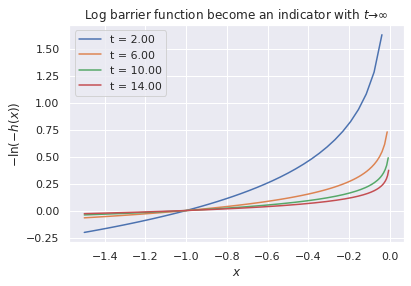

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import linprog
sns.set()

t = np.linspace(2,14, 4)

for t_ in t:
    x = np.linspace(-1.5, 0.0, int(20*t_))
    y = -np.log(-x)
    plt.plot(x,y/t_, label = f't = {t_:.2f}')

plt.title(f'Log barrier function become an indicator with $t \\to \infty$')
plt.ylabel(f'$-\ln(-h(x))$')
plt.xlabel(f'$x$')
plt.legend()
plt.show()

Thus, sequences of auxiliary problems are formed in which the barrier function adds almost nothing to the original function, but starts to penalize noticeably as it approaches the boundary of the feasible set. 

The algorithm can be formulated as follows:
* $t = t_0 >0$, $x_0 \in S$ - correct initialization

For $\mu > 1$ and $k = 1,2,3,\ldots$

* Optimization step $t_k f(x_k) + \varphi(x_k)$ $\to x_{k+1}$
* if $\frac{m}{t} \leq \varepsilon$ - break for loop
* Increase $t$: $t_{k+1} = \mu t_k$

Plot the number of iterations needed to achieve $\varepsilon = 10^{-8}$ accuracy for $n=50, m = 100$, depending on the value of $\mu$.

Consider Newton's method for the target function with fixed step or damped Newton's method. (At [link](https://statweb.stanford.edu/~candes/teaching/acm113/Handouts/sumt.pdf) a Matlab code for the problem is available, you can look into it and understand how to do this problem.)

Consider values $\mu$ on range $[2, 1000]$ with function `mus = np.linspace(2,1000)`

In [ ]:
# Returns function value, gradient and hessian
def barrier(x, A, b, t, c):
    ### YOUR CODE
    return f, g, H

In [ ]:
# Generating problem

np.random.seed(1)

m = 100
n = 50
eps = 1e-8

A = np.random.normal(size=[m, n])
b = 1 + abs(np.random.normal(size=[m,1]))
c = np.random.normal(size=(n,1))
MAXITERS = 500
BETA = .1
ALPHA = .7

In [ ]:
### Finding true solution with arbitrary linprog solver
### YOUR CODE
...

Ellipsis

In [ ]:
### Optimization cycle

In [ ]:
### Visualization of gap

In [ ]:
### Visualization of dependencies of number iteration from \mu